In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
np.random.seed(1)

In [4]:
T = 10
n = 5
l = np.random.randint(5, size=n)
l = l/np.sum(l)
x = np.random.randint(5, size=n)
x = x/np.sum(x)

In [5]:
def regret(min_l, curr_l):
  return (curr_l - min_l)

In [6]:
def online_gd(eta, xt, lt):
  # gradient descent step
  yt = xt - eta*lt

  # projection step
  xt1 = yt/np.sum(yt)

  return xt1

In [7]:
def bco(delta, T):
  # Define the variables needed
  total_regret = 0
  history = []
  xt = x

  for t in range(T):

    # Choose whether to explore or explot based on the value of delta
    bt = np.random.binomial(1, delta)
    #print("bt := ", bt)

    if bt==1:
      # Choose an action at random
      it = random.randint(0, n-1)
      #print("it := ", it)
      
      # playing the move 
      total_regret += regret(l[np.argmin(l)], l[it])
      history.append(total_regret/(t+1))

      l_hat_t = np.zeros(n)
      l_hat_t[it] = (n/delta)*l[it]
      #print("l_hat_t := ", l_hat_t)

      # Online Gradient Descent
      x_t1 = online_gd(0.1, xt, l_hat_t)
      xt = x_t1

      

    else:
      # Choose the action with the highest vale of x
      it = np.argmax(x)
      #print("it := ", it)
      total_regret += regret(l[np.argmin(l)], l[it])
      history.append(total_regret/(t+1))

    #print("Total regret := ", total_regret)
    

  return history


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


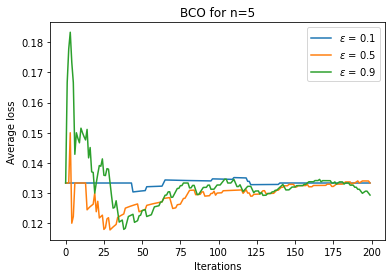

In [12]:
h1 = bco(0.1, 200)
h2 = bco(0.5, 200)
h3 = bco(0.9, 200)

plt.plot(h1, label="$\epsilon$ = 0.1")
plt.plot(h2, label="$\epsilon$ = 0.5")
plt.plot(h3, label="$\epsilon$ = 0.9")
plt.xlabel("Iterations")
plt.ylabel("Average loss")
plt.title("BCO for n=5")

plt.legend()


In [29]:
arms = 10
iters = 1000
eps1 = 0 #Exploitation only
eps2 = 1 # 1% eps greedy
eps3 = 10 #10% eps greedy
eps4 = 100 #Exploration only

#Probability distribution (here, Gaussian) of each arm, index0: mean, index1: variance
#arm_predef_rewards = np.array([[1, 0], [30, 0], [10, 0], [50, 0], [4, 0]])
#arm_predef_rewards = np.random.randint(10, size=(arms, 2))
arm_predef_rewards = np.random.randint(2, size=(arms, 2)) ## For Thompson Sampling

def MAB(arms, eps, iters, decay=0, ucb=0, thomp=0, bootucb=0):
    
    '''
    arms = no. of arms of the multi-arm bandit problem
    eps = range(1, 100), selecting an arm with an eps probability for exploration
    iters = no. of times an arm can be selected 
    '''
    
    #Count of the no. of times each arm was selected, initialized to zero/ones
    arm_hits = np.ones(arms)
    
    #Total rewards gained
    total_reward = 0 
    
    #Count of rewards obtained after each iteration of a play
    iter_rewards = np.zeros(iters)
    
    #Average of rewards gained for each arm
    arm_acc_rewards = np.zeros(arms)

    #Probability distribution (here, Gaussian) of each arm, index0: mean, index1: variance
    #arm_predef_rewards = np.array([[1, 0], [30, 0], [10, 0], [50, 0], [4, 0]])
    #arm_predef_rewards = np.random.randint(10, size=(arms, 2))
    #arm_predef_rewards = np.random.randint(2, size=(arms, 2)) ## For Thompson Sampling
    
    #Initialization of arm rewards for UCB
    arm_ucb_rewards = [np.random.normal(arm_predef_rewards[a][0], arm_predef_rewards[a][1]) for a in range(arms)]

    #Maintaining the computation of the core formula of the UCB algorithm
    arm_ucb1 = np.zeros(arms)

    # Variables for Thompson Sampling
    rewards_1 = np.zeros(arms)
    rewards_0 = np.zeros(arms)
    thomp_probs = np.zeros(arms)
    
    
    #Playing for iters times
    for i in range(iters):

        #Choosing a number between 0 - 100, to be compared with eps value later
        rand = np.random.randint(0, 100)

        if (decay == 1):
            eps = 1 / (1 + i / arms)
            
        if (ucb == 1):
            numerator = np.ones(arms) * 2 * np.log(i+1.001)
            arm_acc_rewards = arm_acc_rewards + np.array(arm_ucb_rewards)

            arm_ucb1 = arm_acc_rewards + np.sqrt(np.divide(numerator, arm_hits)) #, out=np.zeros_like(numerator), where=arm_hits!=0
            #arm_predef_rewards[:,0:1].reshape(-1)
            #arm_ucb1 = np.nan_to_num(arm_ucb1)
            arm_ucb1 = [0 if i==np.inf else i for i in arm_ucb1]
            action = np.argmax(arm_ucb1)
            #print("-> t = "+str(i)+": "+str(arm_acc_rewards)+"\n "+ str(arm_ucb1)+" & action index chosen "+str(action))

        if (bootucb == 1):
            alpha = 1/(1+i)
            delta = 0.1
            q = alpha * delta
            temp = [q for a in range(arms)]
            
            arm_acc_rewards = arm_acc_rewards + np.array(arm_ucb_rewards)
            numerator = np.ones(arms) * 2 * np.log(np.divide(2, q))
            arm_ucb1 = np.array(temp) + arm_acc_rewards + np.sqrt(np.divide(numerator, arm_hits)) 
            #, out=np.zeros_like(numerator), where=arm_hits!=0
            #arm_predef_rewards[:,0:1].reshape(-1)
            #arm_ucb1 = np.nan_to_num(arm_ucb1)
            arm_ucb1 = [0 if i==np.inf else i for i in arm_ucb1]
            action = np.argmax(arm_ucb1)
            #print("-> t = "+str(i)+": "+str(arm_acc_rewards)+"\n "+ str(arm_ucb1)+" & action index chosen "+str(action))

        elif (thomp):
            thomp_probs = [np.random.beta(rewards_1[i] +1, rewards_0[i]+1) for i in range(arms)]
            action = np.argmax(thomp_probs)
        
        elif (rand < eps):
            #Explore - picking an arm randomly
            action = np.random.randint(0, arms)
        
        else:
            #Exploit - picking the arm which gives best returns
            action = np.argmax(arm_acc_rewards)
        
        #print("Arm picked is - " + str(action))
        
        #Calculating the reward obtained by selecting a particular arm (through Gaussian distribution generation)
        action_reward = np.random.normal(arm_predef_rewards[action][0], arm_predef_rewards[action][1])

        if thomp:
            if action_reward >= 0.5 :
                rewards_1[action] += 1

            else:
                rewards_0[action] += 1 
        
        #Incrementing the count of the arm being chosen above
        arm_hits[action]+= 1
        #print("UCB: "+str(ucb)+" Action: " + str(action)+", Arm hits: "+str(arm_hits))
        
        #Cumulative average of the rewards across iterations
        if i == 0:
            iter_rewards[i] = action_reward
        else:
            iter_rewards[i] = ((iter_rewards[i-1] * (i)) + action_reward) / (i+1)
        
        total_reward += action_reward
        
        #Updating the accumulated average rewards for an arm
        #arm_acc_rewards[action] = arm_acc_rewards[action] + action_reward
        #arm_acc_rewards[action] = ( arm_acc_rewards[action] + action_reward ) / 2
        arm_acc_rewards[action] = (( arm_acc_rewards[action] * (arm_hits[action] - 1) ) + action_reward ) / arm_hits[action]
    
    #total_reward /= iters
    return total_reward, arm_hits, arm_acc_rewards, arm_predef_rewards, iter_rewards

In [34]:
tr1, ah1, ar1, apr1, itr1 = MAB(arms, eps1, iters, 0, 0)
tr2, ah2, ar2, apr2, itr2 = MAB(arms, eps2, iters, 0, 0)
tr3, ah3, ar3, apr3, itr3 = MAB(arms, eps3, iters, 0, 0)
tr4, ah4, ar4, apr4, itr4 = MAB(arms, eps4, iters, 0, 0)
tr5, ah5, ar5, apr5, itr5 = MAB(arms, 0, iters, 1, 0) #eps-decay
tr6, ah6, ar6, apr6, itr6 = MAB(arms, 0, iters, 0, 1) #ucb-1
tr7, ah7, ar7, apr7, itr7 = MAB(arms, 0, iters, 0, thomp=1) #Thompson
tr8, ah8, ar8, apr8, itr8 = MAB(arms, 0, iters, bootucb=1) #boot-ucb

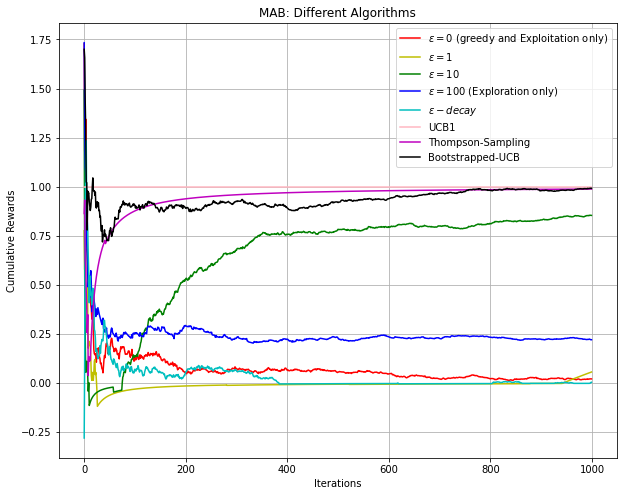

In [35]:
plt.figure(figsize=(10,8))
plt.plot(itr1, c='r')
plt.plot(itr2, c='y')
plt.plot(itr3, c='g')
plt.plot(itr4, c='b')
plt.plot(itr5, c='c')
plt.plot(itr6, c='lightpink')
plt.plot(itr7, c='m')
plt.plot(itr8, c='black')
plt.legend(["$\epsilon=0$ (greedy and Exploitation only)", "$\epsilon=1$", 
            "$\epsilon=10$", "$\epsilon=100$ (Exploration only)", "$\epsilon-decay$", "UCB1",
            "Thompson-Sampling", "Bootstrapped-UCB"]) #, loc ="lower right"
plt.xlabel("Iterations")
plt.ylabel("Cumulative Rewards")
plt.title("MAB: Different Algorithms")
plt.grid()
plt.show()

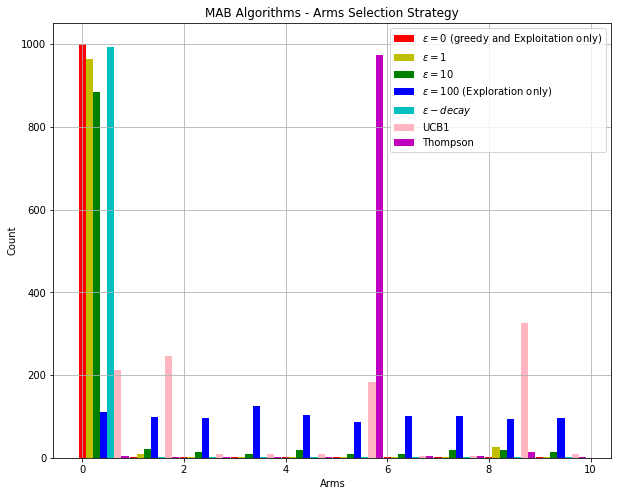

In [20]:
#Displaying the number of arms chosen for the different eps-greedy algorithms
bins = np.linspace(0, arms-1, arms)
plt.figure(figsize=(10, 8))
plt.bar(bins, ah1, width = 0.14, color='r')
plt.bar(bins+0.14, ah2, width=0.14, color='y')
plt.bar(bins+0.28, ah3, width=0.14, color='g')
plt.bar(bins+0.42, ah4, width=0.14, color='b')
plt.bar(bins+0.56, ah5, width=0.14, color='c')
plt.bar(bins+0.70, ah6, width=0.14, color='lightpink')
plt.bar(bins+0.84, ah7, width=0.14, color='m')
plt.legend(["$\epsilon=0$ (greedy and Exploitation only)", "$\epsilon=1$", 
            "$\epsilon=10$", "$\epsilon=100$ (Exploration only)", "$\epsilon-decay$", "UCB1", "Thompson"])
plt.xlabel("Arms")
plt.ylabel("Count")
plt.title("MAB Algorithms - Arms Selection Strategy")
plt.grid()
plt.show()

In [22]:
##Contextual bandits 


import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import load_svmlight_file
##preprocessing the bibtex dataset...into binaray classification for each label
def parse_data(filename):
    with open(filename, "rb") as f:
        infoline = f.readline()
        infoline = re.sub(r"^b'", "", str(infoline))
        n_features = int(re.sub(r"^\d+\s(\d+)\s\d+.*$", r"\1", infoline))
        print(n_features)
        features, labels = load_svmlight_file(f, n_features=n_features, multilabel=True)
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(labels)
    features = np.array(features.todense())
    features = np.ascontiguousarray(features)
    return features, labels
## the preprocessing code has been used as in site: https://nbviewer.org/github/david-cortes/contextualbandits/blob/master/example/online_contextual_bandits.ipynb
X, y = parse_data("/content/Bibtex_data.txt")

1836


In [23]:
## epsilon greedy algorithm for contextual bandits
import random
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
def Epsilon_greedy(X,y,eps,arms,decay=0):
  bandit=[0]*arms
  ##history_for_bandits saves the training instances it has seen and their corresponding labels on which each corresponding bandit is fitted
  history_for_bandits=[[[] for i in range(2)] for j in range(arms)]
  ## count array keeps the track of new training instances added in the history of each bandit
  count=[0]*arms
  ##acc_rewards keeps track of average reward recieved in every 10 iterations.
  acc_rewards=[]
  sum=0
  for i in range(arms):
    bandit[i]=LogisticRegression(solver='lbfgs', warm_start=True)
    ##one logisticRegression object is being called for bandit
  for k in range(1,6):
    ##same data being iterated again with reshuffling.
    X,y=shuffle(X,y)
    for i in range(len(X[:,0:1])):
      rand=random.random()
      ##explore
      if (rand < eps):
        #Explore - picking an arm randomly
            b= np.random.randint(0, arms)
            count[b]+=1
            ##added training instance in the history of bandit[b]
            history_for_bandits[b][0].append(X[i])
            history_for_bandits[b][1].append(y[i][b])
            sum+=y[i][b]
            if i%10==0:
              q=sum/10
              #average reward is being calculated after every 10 iterations.
              acc_rewards.append(q)
              sum=0
              #print(q,i,k)
            if count[b]==5:
              count[b]=0
              try:
                ##bandit{b} is being fitted after every 5 new training samples being added
                bandit[b].fit(history_for_bandits[b][0],history_for_bandits[b][1])
              except:
                count[b]=0
            if decay==1:
              ##for epsilon-decay method
              eps = 1 / (1 + i / arms)
      else:
        score=[]
        for j in range(arms):
          try:
            ##predicting the reward for each bandit
            _,v=bandit[j].predict_proba(X[j].reshape(1,-1))
          except:
              ##MAB FIRST
              v=np.random.beta(3,7)
              score.append(v)
       ##choosing the best bandit     
        b=np.argmax(score)
        sum+=y[i][b]
        if i%10==0:
          #average reward is being calculated  after every 10 iterations
          q=sum/10
          acc_rewards.append(q)
          sum=0
          #print(q,i,k)
  return acc_rewards
 
     
###Preprocessing the dataset X,Y to most important 10 arms(bandits) ->which is a hyperparameter
con=[]
co=[]
lst=[y[:,i:i+1].sum() for i in range(159)]
con = np.argsort(lst)[::-1][:10]
y=y[:,con] 
for j,i in enumerate(y):
  result = any(element == 1 for element in i[:10])
  if result:
    co.append(j)
X=np.array([X[i] for i in co])
y=np.array([y[i] for i in co])
##epsilon greedy being called for different cases
l1=Epsilon_greedy(X,y,0.2,10)
l2=Epsilon_greedy(X,y,0.5,10)
#l3=Epsilon_greedy(X,y,0.1,10)
ls=[i for i in range(0,len(l1)*10,10)]

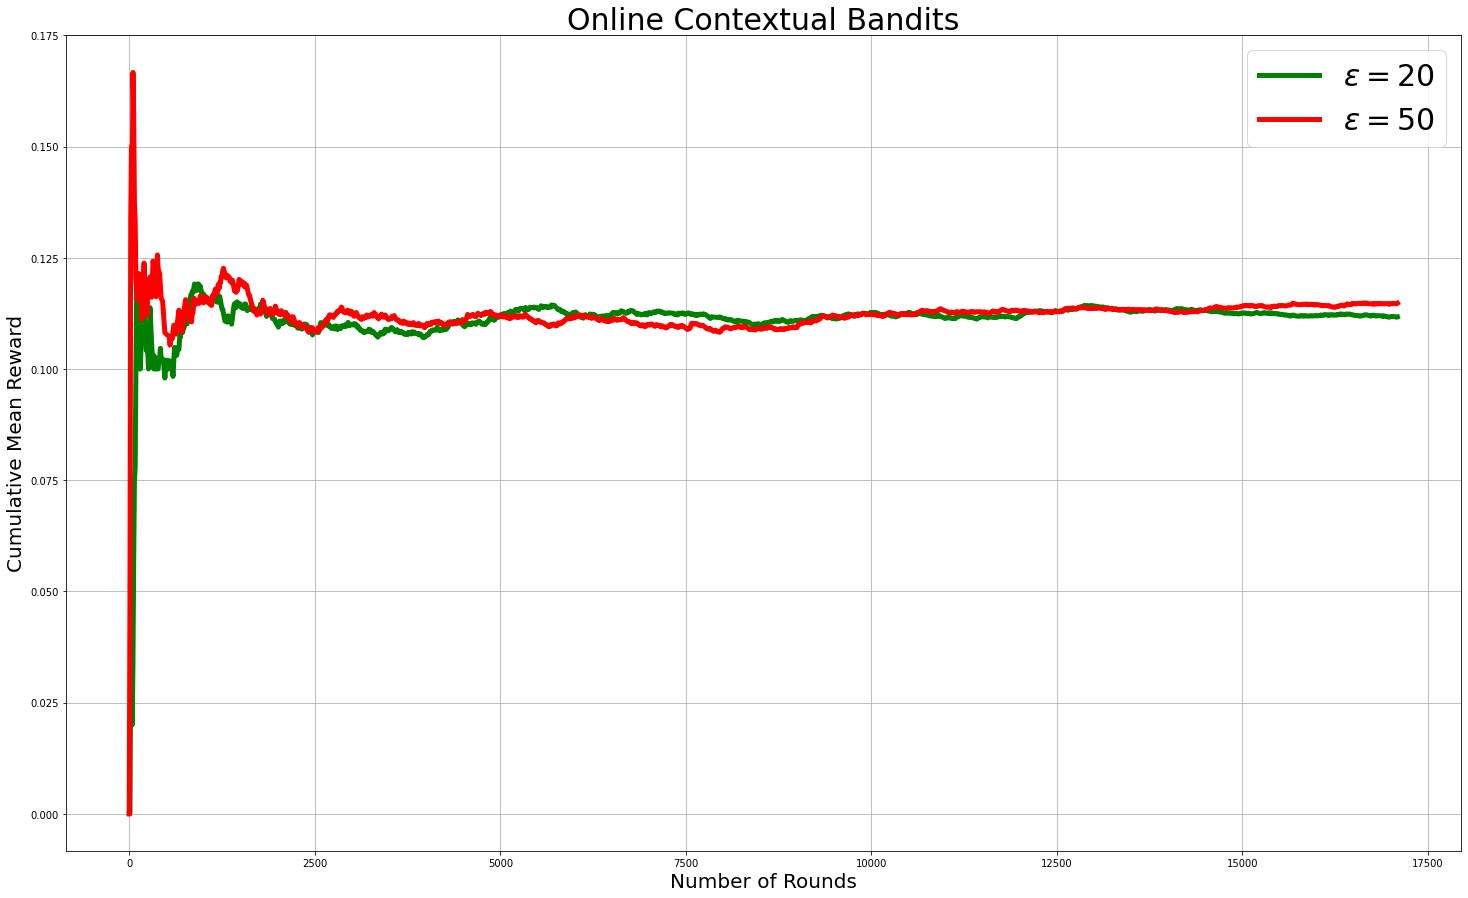

In [24]:
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst):
  reward_lst=np.array(reward_lst)
  me=list()
  for i in range(len(reward_lst)):
      me.append(sum(reward_lst[:i+1]) * 1.0 / (i+1))
  return me

rcParams['figure.figsize'] = 25, 15

plt.plot(ls,get_mean_reward(l1),linewidth=5,color='g')
plt.plot(ls,get_mean_reward(l2),linewidth=5,color='r')
# plt.plot(lst,get_mean_reward(te),linewidth=5,color='b')
plt.legend(["$\epsilon=20$","$\epsilon=50$", 
            "$\epsilon=10$", "$\epsilon=100$ (Exploration only)", "$\epsilon-decay$"],prop={'size': 30})
plt.xlabel("Number of Rounds",size=20)
plt.ylabel("Cumulative Mean Reward",size=20)
plt.title("Online Contextual Bandits",size =30)
plt.grid()
plt.show()